In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
import time as TIME
import math
import re
import random

In [2]:
# 10部件                         1 2 3 4 5 6 7 8 9 10
prior_constrain_p10 = np.array([[0,1,1,1,1,0,0,0,0,0], # 1
                                [0,0,0,0,0,1,0,0,0,0], # 2
                                [0,0,0,0,0,0,0,0,0,0], # 3
                                [0,0,0,0,0,0,1,0,0,0], # 4
                                [0,0,0,0,0,0,0,0,0,0], # 5
                                [0,0,0,0,0,0,0,1,0,0], # 6
                                [0,0,0,0,0,0,0,0,1,0], # 7
                                [0,0,0,0,0,0,0,0,0,0], # 8
                                [0,0,0,0,0,0,0,0,0,1], # 9
                                [0,0,0,0,0,0,0,0,0,0]])# 10
num_of_part_p10 = 10
CT_p10 = 26
time_p10 = np.array([3, 8, 6, 10, 9, 6, 7, 7, 10, 7])
danger_p10 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
need_p10 = np.array([0, 500, 0, 0, 0, 750, 295, 0, 360, 0])
disassembly_side_p10 = np.array([1, -1, 1, 1, 1, 1, 0, 1, -1, 0]) # 1左边，-1右边，0两边都可以

In [3]:
class get_candid:
    def __init__(self, prior_constrain, disassembly_side):
        self.prior_constrain = copy.deepcopy(prior_constrain)
        self.disassembly_side = disassembly_side
        
    def get_can_do_task(self, did_tasks):
        did_tasks_with0_encoding = [abs(ele)-1 for ele in did_tasks]
        self.prior_constrain[did_tasks_with0_encoding, :] = 0
        can_do_tasks = np.argwhere(np.sum(self.prior_constrain, axis=0)==0).reshape(-1).tolist()
        for did_task in did_tasks_with0_encoding:
            can_do_tasks.remove(did_task)
        can_do_tasks = (np.array(can_do_tasks) + 1).tolist()
        can_do_tasks_duplic = copy.deepcopy(can_do_tasks)
        for ele in can_do_tasks_duplic:
            if self.disassembly_side[ele-1] == -1:
                can_do_tasks.remove(ele)
                can_do_tasks.append(-1*ele)
            elif self.disassembly_side[ele-1] == 0:
                can_do_tasks.append(-1*ele)
        return can_do_tasks

# 随机初始化

In [4]:
def init_pop_rondom_method(num_of_part_p, prior_constrain_p, disassembly_side_p, num_of_pop):
    num_of_part = num_of_part_p
    prior_constrain = prior_constrain_p
    disassembly_side = disassembly_side_p
    pops = []
    for _ in range(num_of_pop):
        pop = []
        candidate = get_candid(prior_constrain, disassembly_side)
        for _ in range(num_of_part):
            candid_task = candidate.get_can_do_task(pop)
            choiced_task = np.random.choice(candid_task)
            pop.append(choiced_task)
        pops.append(pop)
    return pops

In [5]:
def check(individual, prior_constrain_p, disassembly_side_p):
    pop = individual
    prior_constrain = copy.deepcopy(prior_constrain_p)
    disassembly_side = disassembly_side_p

    for part in pop:
        if np.sum(prior_constrain, axis=0)[abs(part)-1] != 0:
            return False
        else:
            prior_constrain[abs(part)-1,:] = 0
        if disassembly_side[abs(part)-1] == 1 and part < 0:
            return False
        elif disassembly_side[abs(part)-1] == -1 and part > 0:
            return False
    return True

In [6]:
class Node:
    def __init__(self, main_info, parent, childs, branchNum, visitNum, score):
        self.main_info = main_info
        self.parent = parent
        self.childs = childs
        self.branchNum = branchNum
        self.visitNum = visitNum
        self.score = score

class Tree:
    def __init__(self, depth):
        # tree_layer * main_info * parent_main_info
        # tree_layer: num_ele
        # main_info: num_ele
        self.num_ele = depth
        self.tree = np.zeros(shape=(self.num_ele, self.num_ele*2+1, self.num_ele*2+1))
        self.tree_visit_num = np.zeros(shape=(self.num_ele, self.num_ele*2+1, self.num_ele*2+1))
        self.tree_branch_num = np.zeros(shape=(self.num_ele, self.num_ele*2+1, self.num_ele*2+1))

    def add_node(self, layer, nodes, parent):
        if layer == 0:
            self.tree[layer, nodes] = -1
        else:
            self.tree[layer, nodes, parent] = 1
    
    def update_visit_num(self, layer, choiced_node, parent):
        if layer == 0:
            self.tree_visit_num[layer, choiced_node] += 1
        else:
            self.tree_visit_num[layer, choiced_node, parent] += 1
    
    def update_branch_num(self, pop):
        so = copy.deepcopy(pop)
        so = (np.array(so)+len(pop)).tolist()
        so.reverse()
        for i, ele in enumerate(so):
            if i == 0:
                self.tree_branch_num[self.num_ele-1-i, ele, so[i+1]] = 1
            elif i != self.num_ele-1: 
                self.tree_branch_num[self.num_ele-1-i, ele, so[i+1]] = sum(
                                                                self.tree_branch_num[self.num_ele-i, :, ele])
            else:
                self.tree_branch_num[self.num_ele-1-i, ele] = sum(
                    self.tree_branch_num[self.num_ele-i, :, ele])

In [7]:
def get_ratio(pop, candid_nodes, pops):
    pops = np.array(pops)
    pop = np.tile(pop, (len(candid_nodes),1))
    candid_nodes = np.array(candid_nodes)[...,np.newaxis]
    exp_pop = np.concatenate((pop, candid_nodes), axis=1)
    all_exp_pops = pops[:,:exp_pop.shape[1]]
    ratio_1 = np.array([len(np.argwhere(np.all(ele == all_exp_pops, axis=1)).reshape(-1)) 
                               for ele in exp_pop])
    ratio_2 = np.array([np.argwhere(pops[:,exp_pop.shape[1]-1] == ele).reshape(-1).shape[0] 
                        for ele in candid_nodes.reshape(-1)]) + 0.00001
    ratio = ratio_1/ratio_2
    return ratio

In [8]:
def softmax(f):
    f -= np.max(f)
    return np.exp(f) / np.sum(np.exp(f))
# ****************************************************************
def getChoiceProb(branchInfo, visitNumInfo, visitNumOfParent, temp, p):
    alpha_Hb = (visitNumInfo+0.000000000001)/(visitNumOfParent + 0.000000001)
    alpha_Hb = np.min(np.concatenate((alpha_Hb[np.newaxis,...], 
                                      np.ones(alpha_Hb.shape)[np.newaxis,...])), axis=0)
    beta_Hb = (visitNumInfo+0.000000000001)/(branchInfo + 0.000000001)
    beta_Hb = np.min(np.concatenate((beta_Hb[np.newaxis,...],
                                      np.ones(beta_Hb.shape)[np.newaxis,...])), axis=0)
    if np.random.uniform() >= p:
        logits = -1*np.log(beta_Hb)
    else:
        logits = -1*np.log(alpha_Hb)
    prob = softmax(logits/temp)
    return prob

In [9]:
def init(num_ele, pop_num, t, temperature, prior_constrain, disassembly_side):
    pops = []
    while len(pops)<pop_num:
        pop = []
        candidate = get_candid(prior_constrain, disassembly_side)
        candid_nodes = candidate.get_can_do_task(pop)
        candid_nodes = (np.array(candid_nodes)+num_ele).tolist()
        
        while len(pop) < num_ele: 
            layer = len(pop)
            if layer == 0:
                condid_brance_info = t.tree_branch_num[layer,candid_nodes,0]
                condid_visit_info = t.tree_visit_num[layer,candid_nodes,0]
                parent_visit_info = sum(t.tree_visit_num[layer, :, 0])

                choice_prob = getChoiceProb(condid_brance_info, condid_visit_info, parent_visit_info, 
                                            temperature, 1-len(pops)/pop_num)

                choiced_node = np.random.choice(candid_nodes, p=choice_prob)
                
                
                t.update_visit_num(layer, choiced_node, -1)
                pop.append(choiced_node-num_ele)

            else:
                condid_brance_info = t.tree_branch_num[layer, candid_nodes, pop[-1]+num_ele]
                
                condid_visit_info = np.sum(t.tree_visit_num[layer, candid_nodes], axis=1)
                if flag == 1:
                    condid_brance_info = condid_brance_info*rational
                    condid_visit_info = condid_visit_info*rational
                
                if layer-1 == 0:
                    parent_visit_info = t.tree_visit_num[layer-1, pop[-1]+num_ele, 0]
                else:
                    parent_visit_info = np.sum(t.tree_visit_num[layer-1, pop[-1]+num_ele])
                    if flag == 1:
                        parent_visit_info = parent_visit_info*rational_parent

                choice_prob = getChoiceProb(condid_brance_info, condid_visit_info, parent_visit_info, 
                                            temperature, 1-len(pops)/pop_num)
                choiced_node = np.random.choice(candid_nodes, p=choice_prob)
                
                t.update_visit_num(layer, choiced_node, pop[-1] + num_ele)
                pop.append(choiced_node-num_ele)
            candid_nodes = candidate.get_can_do_task(pop)

            flag = 0
            if len(pops)!=0:
                flag = 1
                rational = get_ratio(pop, candid_nodes, pops)
                rational_parent = get_ratio(pop[:-1], [pop[-1]], pops)
            candid_nodes = (np.array(candid_nodes)+num_ele).tolist()
        t.update_branch_num(pop)
        pops.append(pop)
    return np.array(pops)

### 常规初始化100个个体

In [10]:
start_time = TIME.time()
t = Tree(num_of_part_p10)
pops = init(num_ele=num_of_part_p10, pop_num=100, t = t, temperature = 1, 
                 prior_constrain = prior_constrain_p10, disassembly_side = disassembly_side_p10)
print(TIME.time() - start_time)

0.2401578426361084


# 不同初始化对比

In [23]:
counter_random = []
for _ in range(100):
    counter = 0
    pops = init_pop_rondom_method(num_of_part_p10, prior_constrain_p10, 
                                  disassembly_side_p10, num_of_pop = 1000)
    counter += np.unique(pops, axis=0).shape[0]
    counter_random.append(counter)

In [24]:
t = Tree(num_of_part_p10)

counter_tree = []
for _ in range(100):
    counter = 0
    pops = init(num_ele=num_of_part_p10, pop_num=1000, t = t, temperature = 1, 
                 prior_constrain = prior_constrain_p10, disassembly_side = disassembly_side_p10)
    counter += np.unique(pops, axis=0).shape[0]
    counter_tree.append(counter)

### 关于冷启动问题的一些探索，从下图可以看到，随着建立的树结构的完善，树结构对初始化的指导帮助越大

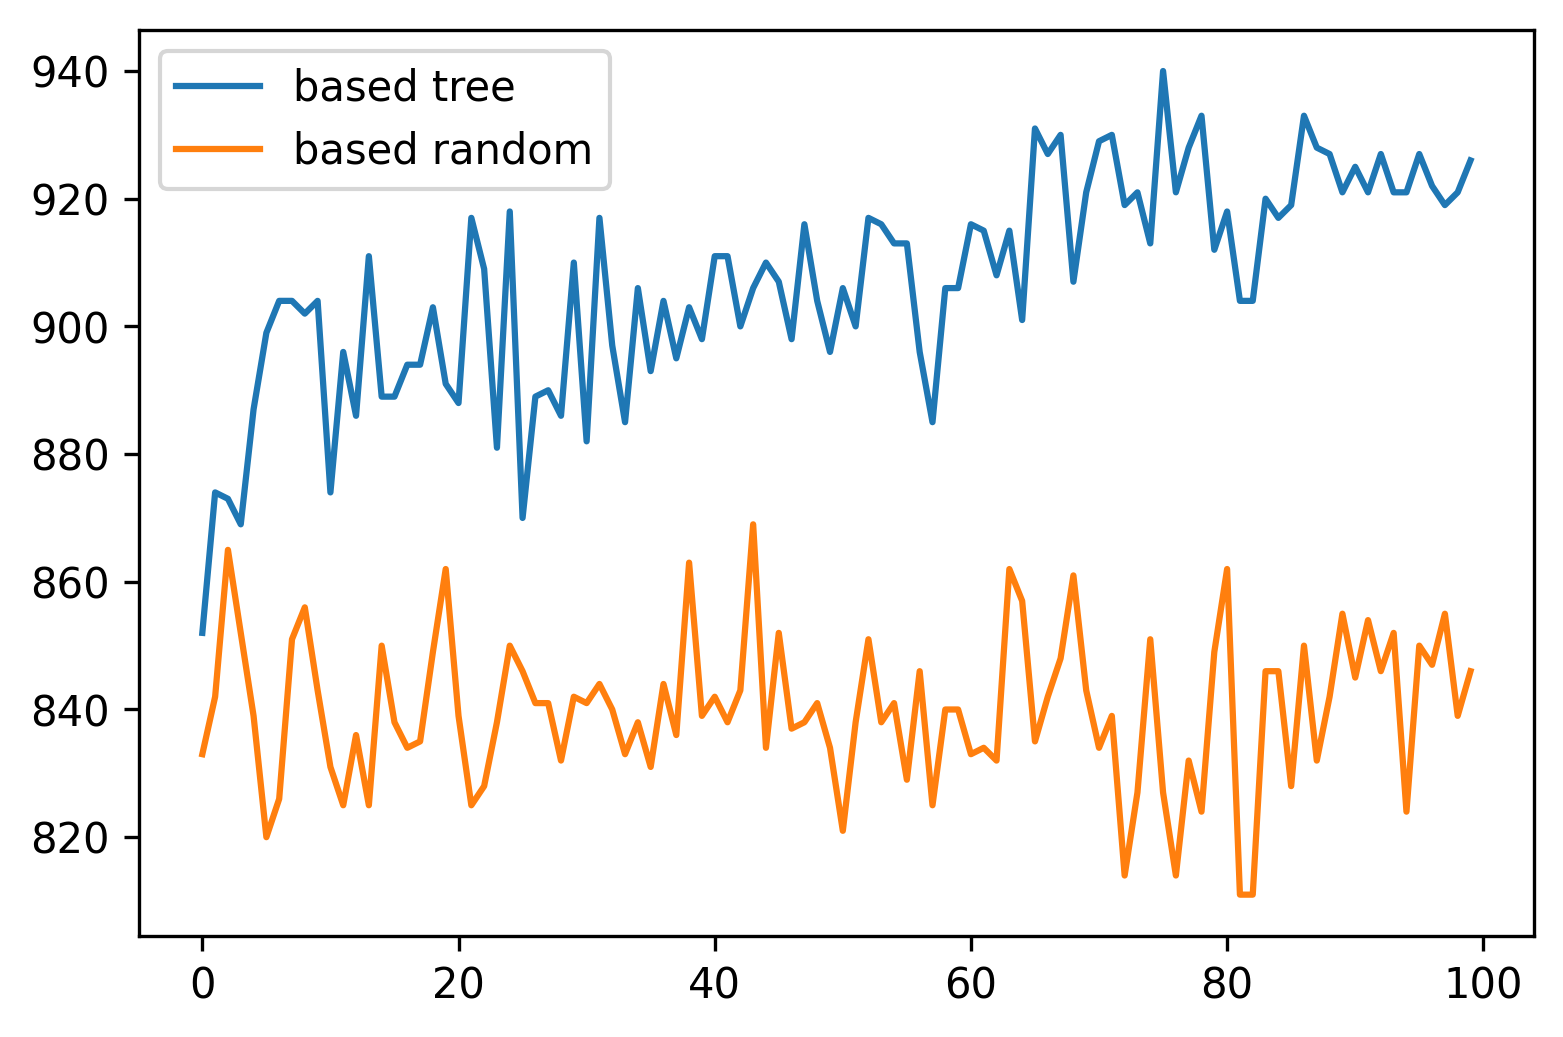

In [25]:
plt.figure(dpi=300)
plt.plot(counter_tree)
plt.plot(counter_random)
plt.legend(['based tree','based random'])